In [1]:
import pickle
with open("../circuit.pickle", 'rb') as handle:
    qc = pickle.load(handle)

In [2]:
calibrations = qc.calibrations
rzx_cal = calibrations['rzx']
rx_cal = calibrations['rx']

In [3]:
rzx_cal.keys()

dict_keys([((3, 2), (0.3333333328625214,)), ((0, 1), (0.3333333328625215,)), ((2, 1), (0.3333333328625215,))])

In [4]:
list(rzx_cal.keys())[0]

((3, 2), (0.3333333328625214,))

In [5]:
type(list(rzx_cal.values())[0])

qiskit.pulse.schedule.ScheduleBlock

In [6]:
custom_rzx_sched = list(rzx_cal.values())[0]
print(custom_rzx_sched)

ScheduleBlock(ScheduleBlock(ScheduleBlock(Play(GaussianSquare(duration=256, sigma=64, width=0, amp=0.1950331982054456, angle=-1.9577239439554657), ControlChannel(6)), name="rescale_cr_inst", transform=AlignLeft()), ScheduleBlock(Play(GaussianSquare(duration=256, sigma=64, width=0, amp=0.03395294325727564, angle=-0.03690020429413254), DriveChannel(2)), name="rescale_cr_inst", transform=AlignLeft()), name="block1", transform=AlignLeft()), ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-0.831407956432985, amp=0.1612936176338676, angle=0.0, name='Xp_d3'), DriveChannel(3), name='Xp_d3'), name="x", transform=AlignLeft()), ScheduleBlock(ScheduleBlock(Play(GaussianSquare(duration=256, sigma=64, width=0, amp=0.1950331982054456, angle=1.1838687096343274), ControlChannel(6)), name="rescale_cr_inst", transform=AlignLeft()), ScheduleBlock(Play(GaussianSquare(duration=256, sigma=64, width=0, amp=0.03395294325727564, angle=3.1046924492956607), DriveChannel(2)), name="rescale_cr_inst", transform

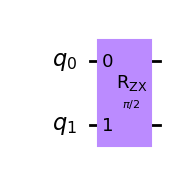

In [7]:
from qiskit import QuantumCircuit
import numpy as np

circuit = QuantumCircuit(2, name='custom_rx')
circuit.rzx(np.pi/2,0,1)
custom_rzx = circuit.to_gate()
circuit.draw('mpl')

In [8]:
from qiskit_ibm_runtime import QiskitRuntimeService
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import InstructionProperties
from qiskit_ibm_provider import IBMProvider
from qiskit_experiments.library import InterleavedRB

In [9]:
#Setting the IBM provider
api_file = "../../ibm_API_key"
with open(api_file, "r") as f:
        api_key = f.readline().strip()
provider = IBMProvider(api_key, instance='ibm-q-ncsu/nc-state/quantum-compiler')
backend = provider.get_backend('ibm_nazca')

In [10]:
backend.target.add_instruction(custom_rzx, {(3,2): InstructionProperties(calibration=custom_rzx_sched)})

In [11]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = (3,2) # make sure it is the qubit added in the backend target

int_exp = InterleavedRB(
    custom_rzx, qubits, lengths, num_samples=num_samples, seed=seed, backend=backend)

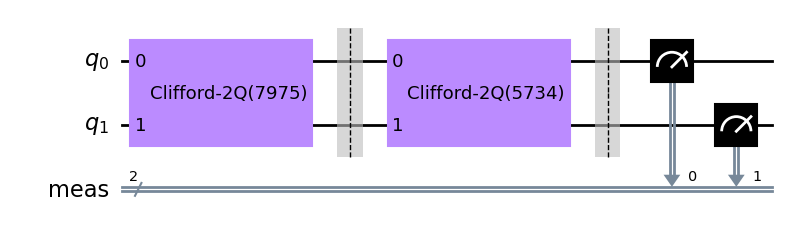

In [12]:
int_exp.circuits()[0].draw('mpl')

In [13]:
int_expdata = int_exp.run(backend).block_for_results()
int_results = int_expdata.analysis_results()

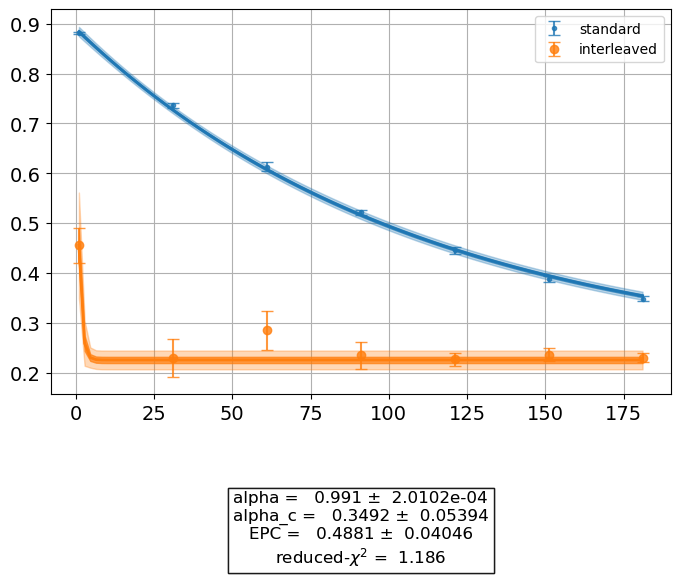

AnalysisResult
- name: @Parameters_InterleavedRBAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 2
  * F_standard(x) = a * alpha ** x + b
  * F_interleaved(x) = a * (alpha_c * alpha) ** x + b
 - success: True
 - number of function evals: 45
 - degree of freedom: 10
 - chi-square: 11.859068684198432
 - reduced chi-square: 1.1859068684198433
 - Akaike info crit.: 5.676497491214211
 - Bayesian info crit.: 8.232726809675246
 - init params:
  * a = 0.42466102291564206
  * alpha = 0.9897480706905458
  * b = 0.25
  * alpha_c = 0.9814340504116026
 - fit params:
  * a = 0.6633296216938932 ± 0.006674668409919946
  * alpha = 0.9909712388760553 ± 0.00020101781517619166
  * b = 0.2265693368301366 ± 0.0062655413559737395
  * alpha_c = 0.34919742285920236 ± 0.05394009659141187
 - correlations:
  * (a, b) = -0.8782871713645841
  * (alpha, b) = -0.824539407595053
  * (b, alpha_c) = -0.1184121135935038
  * (a, alpha_c) = 0.0892780927046863
  * (alpha, alpha_c) 

In [14]:
# View result data
display(int_expdata.figure(0))
for result in int_results:
    print(result)

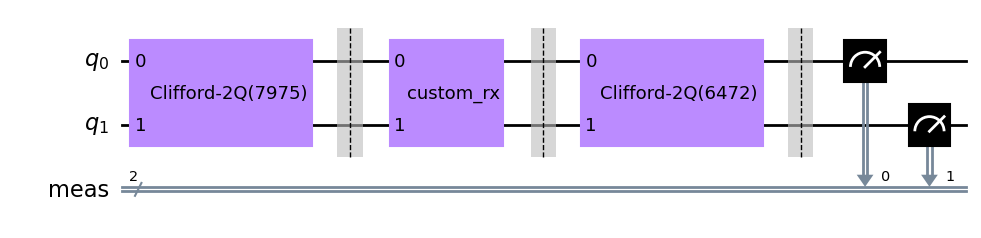

In [15]:
int_exp.circuits()[1].draw(output='mpl')

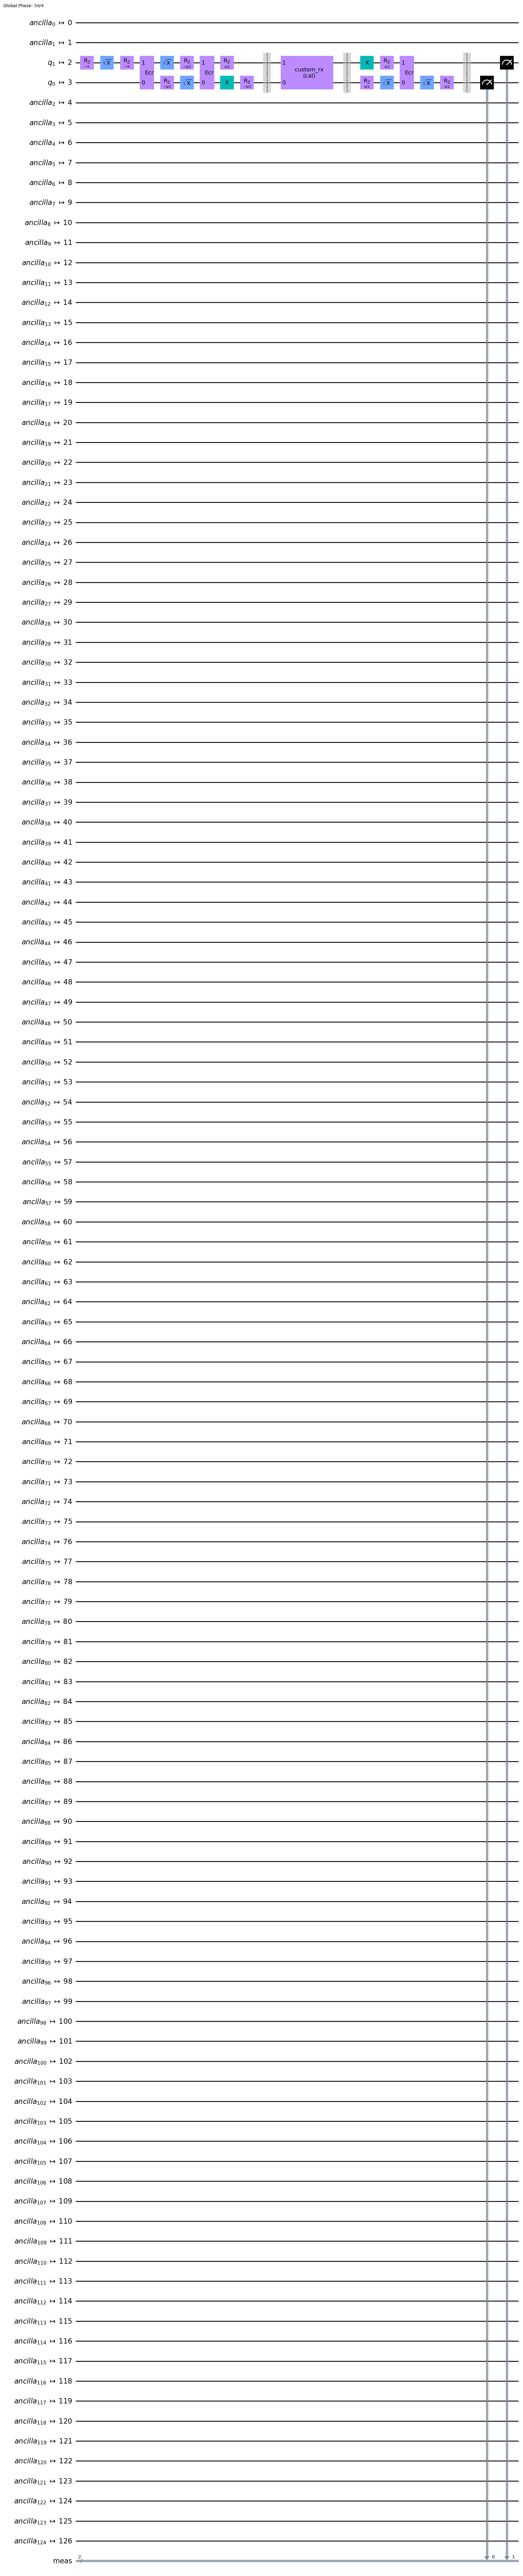

In [16]:
# you can see that the transpiled circuits contain the calibrations
int_exp._transpiled_circuits()[1].draw(output='mpl')